# Exoplanetas Orbitantes con Kepler


### 1.-

Existe una solución única de parámetros para el planeta y estrella a partir de la curva de luz del planeta en tránsito. Estos parámetros son: masa estelar $M_{*}$, radio estelar $R_{*}$, radio del planeta $R_{p}$, distancia orbital $a$ y inclinación orbital $i$. Es importante mencionar que estos parámetros tendrán una única solución siempre y cuando se realicen las siguientes suposiciones: 

 - La órbita del planeta es circular
 - $M_{p} \ll M_{*}$
 - La razón estelar de masa-radio es conocida (a través de $\frac{M_{*}^x}{R_{*}}=k$, donde k es una constante)
 - La luz proviene de una sola estrella
 - Los eclipses poseen un fondo plano
 - El periodo puede ser derivado de la curva de luz

Existen 5 ecuaciones que describen completamente el tránsito de un planeta, de las cuales las siguientes tres son ecuaciones geométricas:

- $\Delta F = (\frac{R_{p}}{R_{*}})^2$
- $\frac{sin(t_{F})}{sin(t_{T})} = (\frac{(1-\frac{R_{P}}{R_{*}})^2-(\frac{a}{R_{*}}cos(i))^2}{(1+\frac{R_{P}}{R_{*}})^2-(\frac{a}{R_{*}}cos(i))^2})^\frac{1}{2}$
- $t_{T} = \frac{P}{\pi}arcsin(\frac{R_{*}}{a}(\frac{(1+\frac{R_{P}}{R_{*}})^2-(\frac{a}{R_{*}}cosi)^2}{1-cos^2i}))^\frac{1}{2}$

Estas tres ecuaciones geométricas , que caracterizan la curva de luz, dependen de 4 observables: el periodo P, la profundidad $\Delta_F$, el tiempo de tránsito $t_T$ y el tiempo de duración de tránsito entre ingreso y egreso $t_F$, que nosotros calcularemos a partir del tránsito del exoplaneta observado en la curva de luz, tal y como detalla la figura 1 del paper de Seager and Mallén-Ornelas. Además de estas tres ecuaciones geométricas, tenemos 2 ecuaciones "físicas" adicionales que nos permiten eliminar la degeneración que se produce al tratar el problema matemático de describir dos esferas pasando una en frente de la otra. Estas ecuaciones son la tercera ley de Kepler y la relación estelar masa-radio:

- $P^2 = \frac{4*\pi^2*a^3}{G(M_{*}+M_{P})}$ 
- $R_{*} = k*{M_{*}}^x$

De estas ecuaciones, podemos derivar los siguientes parámetros de los observables, realizando previamente la aproximación $t_{T}*\pi/P \ll 1$:

- $\frac{R_{P}}{R_{*}}=\sqrt{\Delta F}$ 
- $b = (\frac{(1-\sqrt{\Delta F})^2 - (\frac{t_{F}}{t_{T}})^2(1+\sqrt{\Delta F})^2}{1-(\frac{t_{F}}{t_{T}})^2})^\frac{1}{2}$
- $\frac{a}{R_{*}} = \frac{2P}{\pi}\frac{(\Delta F)^\frac{1}{4}}{((t_{T})^2 - (t_{F})^2)^\frac{1}{2}}$
- $\frac{\rho_{*}}{\rho_{s}} = \frac{32P}{G\pi}\frac{\Delta F^\frac{3}{4}}{(t_{T}^2 - t_{F}^2)^\frac{3}{2}}$
- $i = arccos(b\frac{R_{*}}{a})$

Ahora, presentaremos el análisis del proceso llevado a cabo para obtener las curvas de luz y la obtención de los observables

### 2.-

Para esta parte, se extraerá las curvas de luz para el candidato _KOI-1274.01_.

/home/juanito/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
704.962626


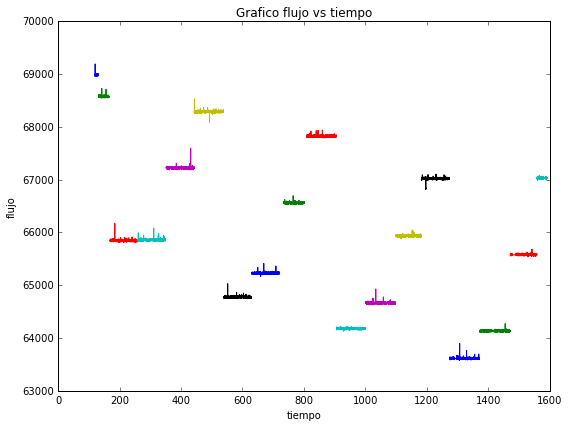

In [1]:
import kplr
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scl
#import scipy as sp

%pylab inline
#Inicializo la interface de kepler:
Kepler = kplr.API()

Koi127401=Kepler.koi(1274.01)
#Periodo del objeto de interés
period=Koi127401.koi_period
print(period)

#Obtengo las curvas de luz
Curva_de_luz=Koi127401.get_light_curves()

#Proceso para plotear las curvas de luz del exoplaneta.

Flujo=[]
Tiempo=[]
Err_Flujo=[]

for elemento in Curva_de_luz:    
    archivo=elemento.open()  #Hay 3 extensiones y la segunda contiene las curvas de luz.
    LC=archivo[1].data #Datos
    Header=archivo[1].header
    
    t = LC["time"]
    f = LC["pdcsap_flux"]
    ferr = LC["pdcsap_flux_err"]
    
    #Procederé a eliminar los nans
    #Para esto, hay una función en la librería numpy de nombre np.isnan(flujos) que lo que hace es identificar si hay o no nans
    #Retornará False si es que no hay nan.
    
    nan = np.isnan(f)
    Tiempo.append(t[~nan])
    Flujo.append(f[~nan])
    Err_Flujo.append(ferr[~nan])


#Ploteando:
plt.subplots(figsize=(8,6))     
for i in range(len(Tiempo)):
    plt.title("Grafico flujo vs tiempo")
    plt.xlabel("tiempo")
    plt.ylabel("flujo")
    plt.plot(Tiempo[i],Flujo[i])

plt.tight_layout()
plt.show()


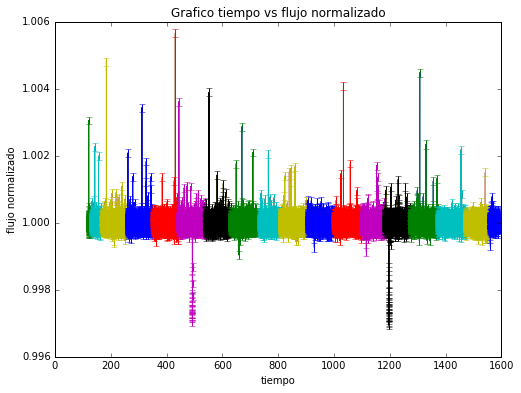

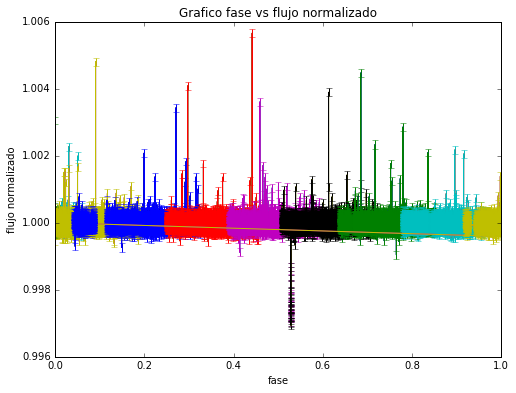

In [2]:


#Definimos una variable para el median filter, que lo debemos incluir en el for
median_filter = []
#Definimos una variable que contenga la división entre el flujo total y lo obtenido por el median filter
normal_flujo = []
#Definimos una variable del error
normal_error = []

#Normalizamos esto mediante el median filter

for i in range(len(Flujo)):
    k=int(np.sqrt(len(Flujo[i])))
    if k%2 == 0: 
        k = k+1
        
    median_filter.append(scl.medfilt(Flujo[i],k))
    normal_flujo.append(Flujo[i]/median_filter[i])
    normal_error.append(Err_Flujo[i]/median_filter[i])
    
fase=[]
n=0 #va a ser un contador
P=704.2 #que es el posible período en días

#Calculando la fase, tengo:

for j in range(len(Flujo)):
    n=(Tiempo[j]-Tiempo[0][0])%P
    fase.append(n/P)

#Ahora solo me queda realizar los gráficos 1)flujo normalizado vs tiempo y 2) flujo normalizado vs fase:
plt.subplots(figsize=(8,6))
for i in range(len(Flujo)):
    plt.plot(Tiempo[i],normal_flujo[i])
    plt.errorbar(Tiempo[i],normal_flujo[i],normal_error[i])
    plt.title("Grafico tiempo vs flujo normalizado")
    plt.xlabel("tiempo")
    plt.ylabel("flujo normalizado")
plt.show()
################################################################################
plt.subplots(figsize=(8,6))
for i in range(len(Flujo)):
    plt.plot(fase[i],normal_flujo[i])
    plt.errorbar(fase[i],normal_flujo[i],normal_error[i])
    plt.title("Grafico fase vs flujo normalizado")
    plt.xlabel("fase")
    plt.ylabel("flujo normalizado")
plt.show()
    

Ahora, realizaré un zoom para observar el tránsito del planeta. 

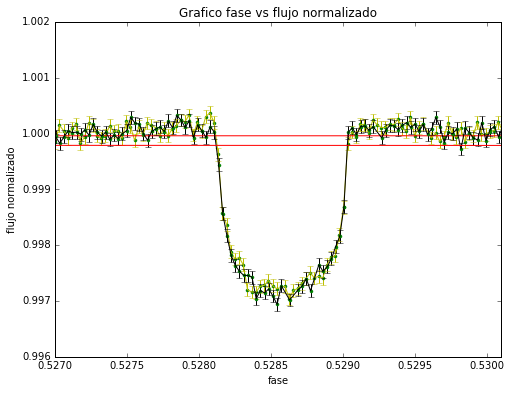

In [3]:
plt.subplots(figsize=(8,6))
for i in range(len(Flujo)):
    plt.plot(fase[i],normal_flujo[i],'g.')
    plt.errorbar(fase[i],normal_flujo[i],normal_error[i])
    plt.xlim(0.527,0.5301)
    plt.ylim(0.996,1.002)
    plt.title("Grafico fase vs flujo normalizado")
    plt.xlabel("fase")
    plt.ylabel("flujo normalizado")
plt.show()

Plotearé el mismo gráfico que recién, pero no faseado y con zoom para lograr ver el tránsito y así conseguir los observables


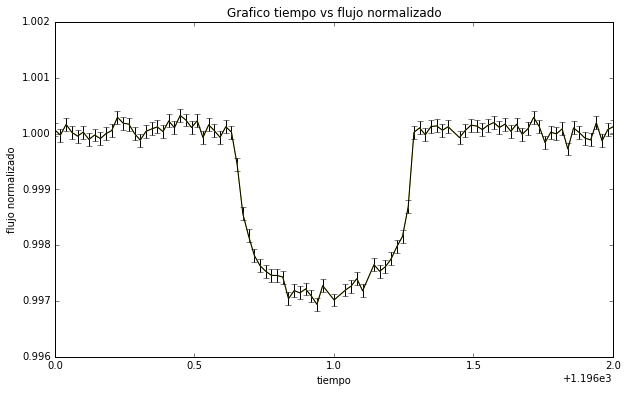

In [4]:
print("Plotearé el mismo gráfico que recién, pero no faseado y con zoom para lograr ver el tránsito y así conseguir los observables")
plt.subplots(figsize=(10,6))
for i in range(len(Flujo)):
    plt.plot(Tiempo[i],normal_flujo[i])
    plt.errorbar(Tiempo[i],normal_flujo[i],normal_error[i])
    plt.xlim(1196,1198)
    plt.ylim(0.996,1.002)
    plt.title("Grafico tiempo vs flujo normalizado")
    plt.xlabel("tiempo")
    plt.ylabel("flujo normalizado")
plt.show()

### 4.-

Los 5 parámetros a determinar son: $\frac{R_{p}}{R_{*}}$, $\frac{a}{R_{*}}$, $\frac{\rho_{*}}{\rho_{sun}}$, _b_, _i_. y para determinar estos al "ojo" debo determinar los 4 observables que mencioné en el inciso 1).

tengo los siguientes valores de los observables: 
   - P=704.2 días
   - $t_T=$0.7 días
   - $t_f$=0.4 días
   - $\Delta F$=0.003



In [5]:
P=704.2
t_T=0.7
t_f=0.4
Delta_F=0.003

print("Utilizando las fórmulas mencionadas en el primer inciso puedo obtener los parámetros deseados.\n\n")

b = np.sqrt(((1-np.sqrt(Delta_F))**2 - (t_f/t_T)**2*(1+np.sqrt(Delta_F))**2)/(1-(t_f/t_T)**2))
Razon_a_Rx = 2*P*Delta_F**(1/4)/(np.pi*np.sqrt(t_T**2 - t_f**2)) #Razon entre el semieje mayor y el radio de la estrella.
i = np.arccos(b*1/Razon_a_Rx)
i_deg = np.degrees(i)
Razon_rhox_rhosun = 3.46*10**(-3)*P*Delta_F**(3/4)/(t_T**2 - t_f**2)**(3/2) #razon entre las densidades de la estrella y el Sol. 

#print "asdfa = ", 1/np.sqrt(Delta_F)

print "El valor de la razón entre el radio del planeta y el radio de la estrella es:", np.sqrt(Delta_F)
print "El valor del parámetro de impacto es:", b
print "El valor de la razón entre la distancia orbital y el radio de la estrella es:", Razon_a_Rx
print "El valor de la razón entre la densidad de la estrella y la densidad del sol es:", Razon_rhox_rhosun
print "El valor del ángulo de inclinación orbital es:", i_deg #en grados

Utilizando las fórmulas mencionadas en el primer inciso puedo obtener los parámetros deseados.


El valor de la razón entre el radio del planeta y el radio de la estrella es: 0.0547722557505
El valor del parámetro de impacto es: 0.887260112734
El valor de la razón entre la distancia orbital y el radio de la estrella es: 780.403437625
El valor de la razón entre la densidad de la estrella y la densidad del sol es: 7.38343030303
El valor del ángulo de inclinación orbital es: 89.9348589867


Al observar la razón entre el radio del planeta y el radio de la estrella noto que esta estrella es ~18 veces más grande que el planeta. Ahora si decimos que la estrella es equivalente al Sol y además sé que el sol es ~12 veces más grande que Saturno por lo que de modo a escala el planeta puede ser comparable al tamaño de Saturno. La estrella es ~7 veces más densa que el Sol, se puede deducir que es más masivo que nuestro Sol. Al observar el ángulo de inclinación orbital noto que es casi de 90° lo que me dice que el tránsito del exoplaneta lo vemos casi exclusivamente en la perisferia de la estrella.

Con respecto a la exactitud de estos datos. En paper destacaba que es razonable decir que las órbitas de los exoplanetas son circulares para períodos cortos ($<4.3 días$), sin embargo el período de este planeta es de 704.2 días, es un período largo por lo que no es muy razonable decir que la órbita de este exoplaneta sea circular, por lo tanto se puede inferir que los cálculos hechos no son del todo exactos.

### 4.- 

Para ajustar una curva de luz teorica utilizaré el modulo _"BATMAN"_. 


In [6]:
rad_p=np.sqrt(Delta_F) 

import batman
## Defino los parametros. Utilizé el ejemplo que aparece en la siguiente pagina: ### http://astro.uchicago.edu/~kreidberg/batman/tutorial.html

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 704.2                    #orbital period
params.rp = rad_p                     #planet radius (in units of stellar radii)
params.a = Razon_a_Rx                 #semi-major axis (in units of stellar radii)
params.inc = i_deg                    #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

t = np.linspace(1, 4, 2000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

  



Al observar los parámetros de batman me encuentro con el problema del __Limb Darkening__, éste es un efecto optico observado en las estrellas, en las cuales el centro de estas se ve más brillante que sus bordes. Este efecto ocurre porque tanto la densidad como la temperatura de la estrella disminuyen a medida que la distancia al centro aumenta.

Existen leyes para los modelos de limb_darkening que ajustan un buen tranito de planetas. Estas leyes son:

 - Lineal: $I(\mu) = I_0[1 - u(1-\mu)]$
 - Cuadrática: $I(\mu) = I_0[1 - u_1(1-\mu)- u_2(1-\mu)²]$
 - Raiz cuadrada: $I(\mu) = I_0[1 - u_1(1-\mu)- u_2(1-\mu^{1/2})]$
 - Logaritmica: $I(\mu) = I_0[1 - u_1(1-\mu)- u_2\mu ln(\mu)]$
 - Exponencial: $I(\mu) = I_0[1 - u_1(1-\mu)- u_2/exp(1-\mu)]$
 - No Lineal: $I(\mu) = I_0[1 - u_1(1-\mu^{1/2})- u_2(1-\mu) - u_3(1-\mu^{3/2}) - u_4(1-\mu²)]$

Para lograr hacer el ajuste correspondiente, necesito obtener los coeficientes. Para esto, Tenemos una tabla de datos procesadas de ATLAS9, un modelo de atmosferas estelares, con información sobre cada intensidad($I_ν$) para distintos $\mu$ = cos ($\theta$) en una amplia gama de longitudes de ondas. Para encontrar los coeficientes de limb darkening lo primero que hay que hacer es transformar cada columna de datos a intensidad en longitud de onda($I_\lambda$), mediante la fórmula:

  $I_\lambda = I_\nu \frac{d\nu}{d\lambda}$
  
donde

  $\frac{d\nu}{d\lambda} = \frac{c}{\lambda²}$
  
Luego se transforma esta intensidad a número de fotones al dividir la intensidad por la energía de cada fotón, que esta dada por: hc/$\lambda$. Finalmente, integramos numericamente los valores de la intensidad teorica para cada $\mu$ sobre todo el espectro de longitudes de onda, por la funcion de respuesta de Kepler (efectos del filtro utilizado en Kepler sobre los datos) para obtener la intensidad observada.

  $I_{obs,phot}(\mu) =\frac{\int S(\lambda)I_{teo,\lambda}(\mu) d\lambda}{\int S(\lambda) d\lambda}$
  
Y al normalizar esta ecuación
   
   $\frac{I_{obs,phot}(\mu)}{I_{obs,phot}(1)} = \int S(\lambda)I_{teo,\lambda}(\mu) d\lambda $
   
es decir, la razón entre la intensidad en una región dada por $\mu$ de la estrella respecto a la intensidad en su centro. Una vez obtenidos estos valores podemos realizar un gráfico I($\mu$)/I(1) vs $\mu$ para encontrar cual de las distintas leyes de limb darkening ajusta mejor a nuestros datos.

In [7]:
## Procedimiento para obtener los coeficientes del Limb_Darkening.

from scipy.integrate import simps
from scipy.optimize import curve_fit

h = 6.626*10**(-27)

datos = np.loadtxt('grav_4.5_lh_1.25.txt', unpack=True)

#dividir intensidad por 10^5 y multiplicar por I(1)

for i in range(2, len(datos)):
    datos[i] = np.multiply(datos[i],datos[1]) #solo los mu distintos de 1
    datos[i] = np.divide(datos[i],10**(5))

#dividir todas las intensidades por lambda y por h

for i in range(1, len(datos)):
    datos[i] = np.divide(datos[i], h*datos[0])
#datos de la normalized response function

kpr = np.loadtxt('kepler_response_hires1.txt', unpack=True)

#borramos longitudes de onda que no estan en datos

a=0
for i in range(len(kpr[0])): #la longitud de onda es la primera columna
    match=0
    for j in range(len(datos[0])):
        if kpr[0][i-a]==datos[0][j]:
            match = 1 #si son iguales los conserva, si match igual 0, elimina el dato
    if match==0:
        kpr = np.delete(kpr,i-a,1)
        a=a+1

### No alcancé a hacer más XD

#### Fuentes:

> http://astro.uchicago.edu/~kreidberg/batman/ Para ajustar la curva de luz teórica (Batman)

> http://arxiv.org/pdf/1507.08285v3.pdf Para usar batman.

> https://ui.adsabs.harvard.edu/#abs/2003ApJ...585.1038S/abstract

> https://github.com/nespinoza/limb-darkening/blob/master/response_functions/standard/kepler_response_hires1.txt saqué el response function para hacer el match con los datos de ATLAS9

> http://mnras.oxfordjournals.org/content/450/2/1879.abstract paper de Espinoza + Jordan.